# DO APERTURE PHOTOMETRY FOR A SINGLE STAR

In [1]:
## load Libraires
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.table import Table
from scipy import interpolate
from shapely.geometry import LineString, Point
from astropy.stats import sigma_clipped_stats
import requests,io
!pip install photutils
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


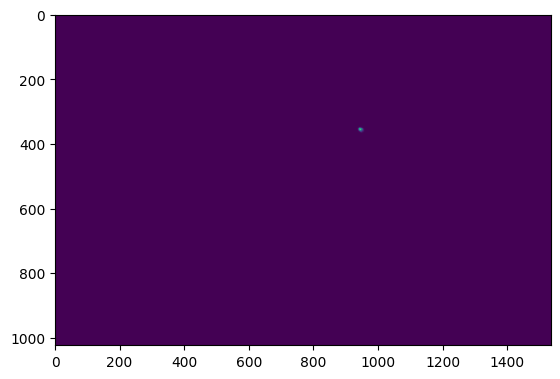

In [15]:
## Load image
dir="/content/sample_data/"
fits1 = fits.open(dir+"altair_Blue_0012.fits")
head = fits1[0].header
image = fits1[0].data
plt.imshow(image)

Get noise image (background and Poisson error)

In [21]:
## First mask sources
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

sigma_clip = SigmaClip(sigma=3.0)
threshold = detect_threshold(image, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image, threshold, npixels=10)
footprint = circular_footprint(radius=10)

srcmask = segment_img.make_source_mask(footprint=footprint)
#plt.imshow(srcmask)

## Get background image with sources masked
from photutils import Background2D,MedianBackground
from astropy.stats import SigmaClip
from photutils.utils import calc_total_error
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(image,(50,50),filter_size=(3,3),sigma_clip=sigma_clip,  ## this is the background and its noise
                   bkg_estimator=bkg_estimator,mask=srcmask)
erimage = calc_total_error(image-bkg.background, bkg.background_rms, 1.5)  ## this is the Poisson error added to background noise

<ipython-input-21-c5a23751610a>:14: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D,MedianBackground
<ipython-input-21-c5a23751610a>:14: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D,MedianBackground


Text(0, 0.5, 'ypix')

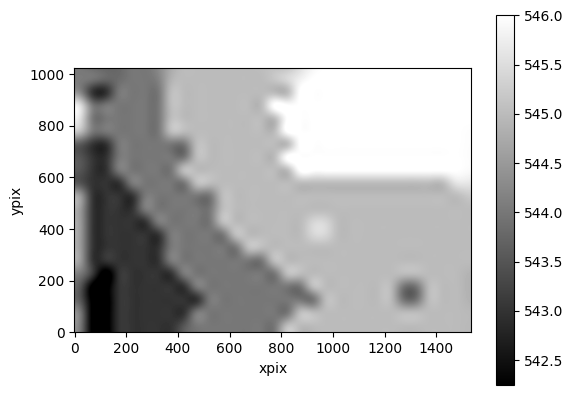

In [23]:
## Background
lo,up = np.percentile(bkg.background,1),np.percentile(bkg.background,99)
plt.figure()
plt.imshow(bkg.background,cmap='gray',origin='lower',clim=(lo,up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')


Text(0, 0.5, 'ypix')

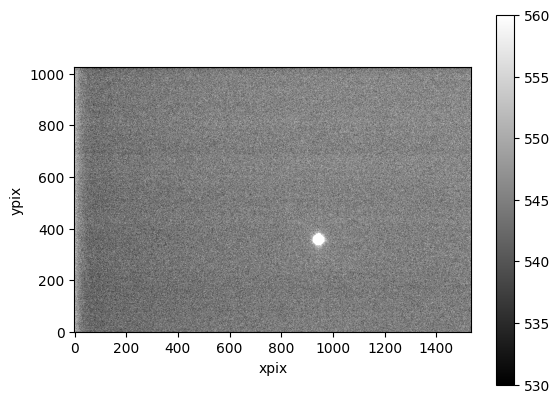

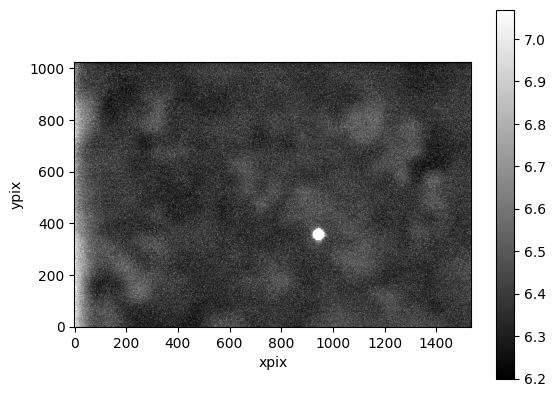

In [22]:
## Image and noise Plot
lo,up = np.percentile(image,1),np.percentile(image,99)
plt.figure()
plt.imshow(image,cmap='gray',origin='lower',clim=(lo,up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')
plt.figure()
lo,up = np.percentile(erimage,1),np.percentile(erimage,99)
plt.imshow(erimage,cmap='gray',origin='lower',clim=(lo,up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')

## Get central position of star with initial guess

[945.3091874  355.59233562]


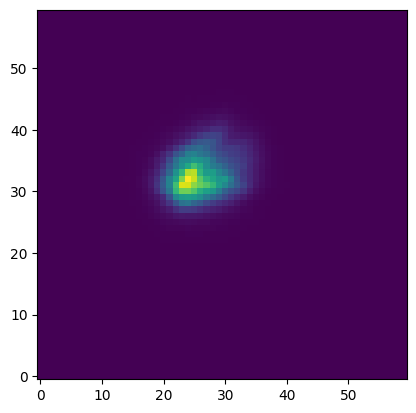

In [25]:
## Estimate position with an initial position guess of the star with centroid
pos_guess = [948,354]   ## initial guess (x,y) (CHANGE TO YOUR STAR POSITION!)
from photutils.centroids import centroid_com, centroid_2dg  #load centroid libraries
img = image[pos_guess[1]-30:pos_guess[1]+30,pos_guess[0]-30:pos_guess[0]+30]#select subportion of 60x60 image
plt.imshow(img,origin='lower')
position = centroid_com(img)+pos_guess-[30,30]
print(position)

Do aperture photometry

 id      xcenter           ycenter      ...  aperture_sum_27  aperture_sum_err_27
           pix               pix        ...                                      
--- ----------------- ----------------- ... ----------------- -------------------
  1 945.3091874034697 355.5923356213301 ... 3720340.791614704  1610.0732712243419
[ 786.14102779 1003.2753385  1177.71787507 1315.80589801 1415.86565347
 1480.23647438 1518.90468391 1541.94458351 1555.70729291 1564.06858607
 1569.53065831 1573.39932881 1576.46501877 1579.07747235 1581.41857315
 1583.62194305 1585.7345519  1587.8110299  1589.85972308 1591.92721844
 1594.02082841 1596.15424912 1598.32221081 1600.54604995 1602.82826004
 1605.19110257 1607.60029165 1610.07327122]


Text(0, 0.5, 'flux/fluxerr')

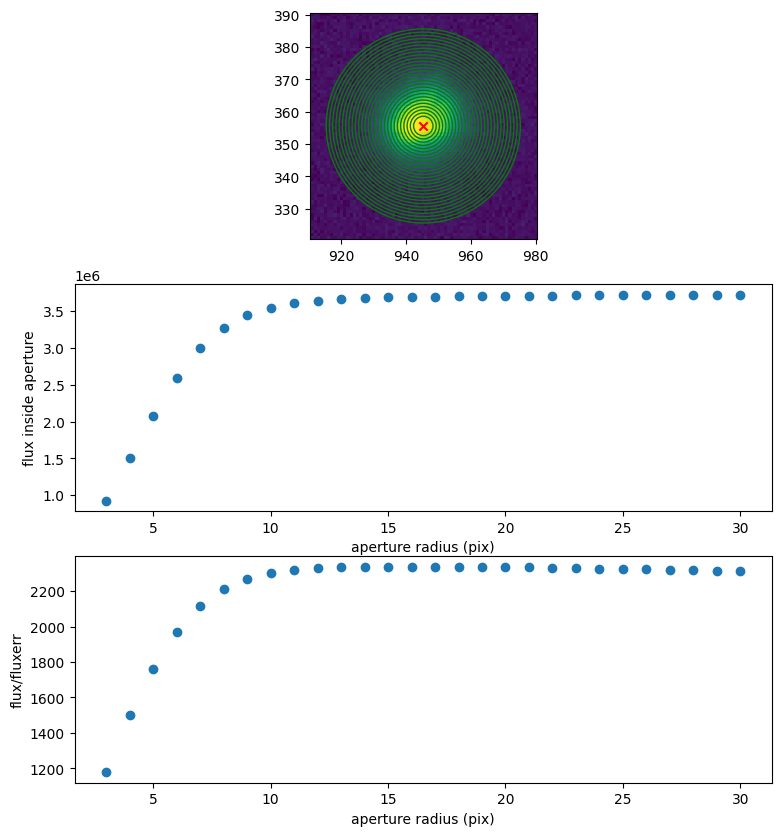

In [36]:
## Get several apertures for one star position (you could have more positions)
from photutils.aperture import CircularAperture
radii = np.arange(3,31)  # radii (pix) of circular apertures
aperture = [CircularAperture(position, r=r) for r in radii] # define circular apertures

## Perform aperture photometry (sum of all pixels within aperture) SUBTRACTING first background found previously
phot_table = aperture_photometry(image-bkg.background, aperture,error=erimage)
print(phot_table)  ## print table
y = np.asarray([phot_table['aperture_sum_'+str(i)] for i in np.arange(0,radii.size)],dtype=float)
ery = np.asarray([phot_table['aperture_sum_err_'+str(i)] for i in np.arange(0,radii.size)],dtype=float)
y=np.reshape(y, (len(y),))
ery=np.reshape(ery, (len(ery),))
print(ery)

## Plot both: curve growth and image with apertures
from astropy.visualization import simple_norm
fig,ax = plt.subplots(3,figsize=(9,10))
norm = simple_norm(img,'log',percent=99.)
ax[0].imshow(image,norm=norm,cmap='viridis', aspect=1, interpolation='nearest')
ax[0].scatter(position[0],position[1],color='red',marker='x')
for r in radii:
  circle = plt.Circle(position,r,color='green',fill=False)
  ax[0].add_artist(circle)
ax[0].set_xlim([position[0]-35,position[0]+35])
ax[0].set_ylim([position[1]-35,position[1]+35])
# plot curve of growth
ax[1].errorbar(radii,y,yerr=ery,fmt='o')
ax[1].set_xlabel('aperture radius (pix)')
ax[1].set_ylabel('flux inside aperture')
# plot flux/fluxerr (S/N)
ax[2].errorbar(radii,y/ery,fmt='o')
ax[2].set_xlabel('aperture radius (pix)')
ax[2].set_ylabel('flux/fluxerr')

In [37]:
## Final flux and error at a given radius. All stars in the same image should have SAME radius
radius = 22 # (CHANGE TO YOUR RADIUS!) -choose radius (here large radius since curve of growth is nice -it has an asymptotic value- but if not take a smaller radius where S/N is high, i.e ~16 in this example)
flux = y[np.round(radii) == np.round(radius)]
error = ery[np.round(radii) == np.round(radius)]
print("    Star flux (counts): %f +/- %f" %(flux,error))
print("    Star flux (counts) per second: %f +/- %f" %(flux/head['EXPTIME'],error/head['EXPTIME']))

    Star flux (counts): 3711345.845920 +/- 1591.927218
    Star flux (counts) per second: 37113458.459203 +/- 15919.272184


<ipython-input-37-32461374e51a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("    Star flux (counts): %f +/- %f" %(flux,error))
<ipython-input-37-32461374e51a>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("    Star flux (counts) per second: %f +/- %f" %(flux/head['EXPTIME'],error/head['EXPTIME']))
